### Imports and functions

In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import tree
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
from mlxtend.plotting import plot_confusion_matrix
from xgboost import XGBClassifier
import xgboost as xgb
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report


In [113]:
def find_categorical_columns(data):
    columns = []
    for column in data.columns:
            unique_values = data[column].nunique()    #number of unique values               
            if unique_values in [1, 2, 3, 4,5]:
                print(f"{column} : {unique_values} unique values.")
                data[column] = data[column].astype('category')
                columns.append(column)
    print('done converting to categorical . . .')
    return columns    

In [114]:
#check for infinite values 
def handel_infinite_values(data):
    if data.isin([np.inf, -np.inf]).any().any():
        infinite_values = data.isin([np.inf, -np.inf])

        # Display rows with infinite values
        rows_with_infinite = data[infinite_values.any(axis=1)]
        print(f"Count of Rows with Infinite Values: {len(rows_with_infinite)}")

        # Replace infinite values with NaN
        data = data.replace([np.inf, -np.inf], np.nan)
        print('cleaning is done . . .')
        
    else:
        print('No Infinite Values Present')
        data.isin([np.inf, -np.inf]).sum().sum()
    return data

In [115]:
def handele_nan_values(data):
    # Check for NaN values
    if data.isnull().any().any():
        print(f"Count of NaN values:{data.isnull().sum().sum()}")
        # Handle NaN values
        data = data.fillna(data.mean()) 
        data.isnull().sum().sum()
        print("cleaning is done . . .")
    else:
        print("No NaN Values are Present")
        data.isnull().sum().sum()
    return data

In [116]:
def custom_encode(data, column_name):
    unique_values = data[column_name].unique()
    print(f"Categories : {unique_values}")
    encoding_dict = {value: index for index, value in enumerate(unique_values)}
    
    data[column_name] = data[column_name].map(encoding_dict)
    unique_values_encoded = data[column_name].unique()
    print(f"Encoded Categories : {unique_values_encoded}")
    return data
    

In [117]:
def handle_duplicates(data):
    # Check for duplicated records
    duplicates = data[data.duplicated(keep=False)]
    shape = data.shape
    if duplicates.empty:
        print("No duplicated records found.")
        return data

    print(f"Count of Duplicated Records: {len(duplicates)}")
    data = data.drop_duplicates(keep='first')
    new_shape = data.shape
    print(f"Keeping first occurrence of duplicated records.\nShape Before Cleaning: {shape},\nShape After Cleaning: {new_shape}")
    return data

In [118]:
def handle_correlated_features(data, high_threshold=0.95, low_threshold=0.2):
    """
    Removing Highly Correlated Features:
    Why? When two or more features in your data are very similar, it can confuse some types of analyses or machine learning models.

    What to do? Look for pairs of features that are almost the same. If you find them, you might remove one to simplify your analysis or model.

    Removing Lowly Correlated Features:
    Why? Some features might not be very useful for predicting what you're interested in (like your target variable).

    What to do? Identify features that don't seem to change much when your target variable changes. If they don't help much, consider getting rid of them.
    """

    # Calculate the correlation matrix
    corr_matrix = data.corr().abs()

    high_mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)
    low_mask = np.tril(np.ones_like(corr_matrix, dtype=bool), k=-1)

    # Get the indices of feature pairs with correlation above the high threshold
    high_pairs_to_drop = [(i, j) for i in range(corr_matrix.shape[0]) for j in range(i + 1, corr_matrix.shape[1]) if high_mask[i, j] and corr_matrix.iloc[i, j] >= high_threshold]

    # Get the indices of feature pairs with correlation below the low threshold
    low_pairs_to_drop = [(i, j) for i in range(corr_matrix.shape[0]) for j in range(i + 1, corr_matrix.shape[1]) if low_mask[i, j] and corr_matrix.iloc[i, j] <= low_threshold]

    if not high_pairs_to_drop and not low_pairs_to_drop:
        print("No highly or lowly correlated features found.")
        return data
    if not high_pairs_to_drop:
        print("No highly correlated features found.")
    if not low_pairs_to_drop:
        print("No lowly correlated features found.")
    
    print("Highly Correlated Features:")
    for i, j in high_pairs_to_drop:
        print(f"{data.columns[i]} - {data.columns[j]} : {corr_matrix.iloc[i, j]}")

    print("\nLowly Correlated Features:")
    for i, j in low_pairs_to_drop:
        print(f"{data.columns[i]} - {data.columns[j]} : {corr_matrix.iloc[i, j]}")

    # Combine the feature pairs to drop
    all_pairs_to_drop = high_pairs_to_drop + low_pairs_to_drop

    # Remove highly and lowly correlated features
    df_cleaned = data.drop(columns=[data.columns[i] for i, _ in all_pairs_to_drop])

    print(f"\nRemoved {len(all_pairs_to_drop)} correlated features.")
    
    return df_cleaned


In [119]:
import seaborn as sns

def explore_features(data):
    # Create subplots
    fig, axes = plt.subplots(nrows=data.shape[1], ncols=1, figsize=(10, 4 * data.shape[1]))
    fig.subplots_adjust(hspace=0.5)

    # Iterate through columns
    for i, (colname, coldata) in enumerate(data.iteritems()):
        ax = axes[i]

        # # Plot based on data type
        if pd.api.types.is_numeric_dtype(coldata):
            # Handle numeric (int and float) data
            coldata.plot(kind='hist', ax=ax)
            ax.set_title(f'Distribution of {colname}')
            ax.set_xlabel(colname)
            ax.set_ylabel('Frequency')
        # if pd.api.types.is_numeric_dtype(coldata):
        #     # Handle numeric (int and float) data
        #     sns.histplot(coldata, kde=True, ax=ax)
        #     ax.set_title(f'Distribution of {colname}')
        #     ax.set_xlabel(colname)
        #     ax.set_ylabel('Frequency')

        elif pd.api.types.is_categorical_dtype(coldata):
            # Handle categorical data
            sns.countplot(x=colname, data=data, ax=ax)
            ax.set_title(f'Count of {colname}')
            ax.set_xlabel(colname)
            ax.set_ylabel('Count')

        else:
            # Handle other data types (assuming non-numeric and non-categorical)
            ax.text(0.5, 0.5, f'Unsupported data type\n({pd.api.types.infer_dtype(coldata)})', 
                    ha='center', va='center', fontsize=12, color='red')
            ax.axis('off')

    plt.show()


In [120]:
from sklearn.metrics import ConfusionMatrixDisplay

def traditional_classification(model, X_train, X_test, y_train, y_test):
    clf = model
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred) * 100
    f1 = f1_score(y_test, y_pred) * 100

    print(f"Accuracy of {model}: {acc}%" )
    print(f"F1 Score of {model}: {f1}%" )

    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plot_confusion_matrix(conf_mat = cm, figsize=(6, 6), cmap = plt.cm.Blues)
    plt.xlabel('Predictions', fontsize=18)
    plt.ylabel('Actuals', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    return clf, acc,f1

In [121]:
def cross_validation_classification(model, X_train, X_test, y_train, y_test, folds):
  
  y_pred = cross_val_predict(model, X_train, y_train, cv = folds)
  accuracy = accuracy_score(y_pred,y_train)*100
  percision = precision_score(y_train, y_pred)*100
  recall = recall_score(y_train, y_pred)*100
  f1 = f1_score(y_train, y_pred)*100
  
  print(f"Accuracy_score: {accuracy}",)
  print(f"precision_score: {percision}")
  print(f"recall_score: {recall}")
  print(f"f1_score: {f1}")
  
  cm = confusion_matrix(y_train, y_pred)
  fig, ax = plot_confusion_matrix(conf_mat = cm, figsize=(6, 6), cmap = plt.cm.Blues)
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()

### Load Data

In [122]:
data = pd.read_csv("Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv")
print(data.shape)

(225745, 79)


In [123]:
data.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


In [124]:
data.describe()

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Bwd Packet Length Mean,Bwd Packet Length Std,Flow Bytes/s,Flow Packets/s,Flow IAT Mean,Flow IAT Std,Flow IAT Max,Flow IAT Min,Fwd IAT Total,Fwd IAT Mean,Fwd IAT Std,Fwd IAT Max,Fwd IAT Min,Bwd IAT Total,Bwd IAT Mean,Bwd IAT Std,Bwd IAT Max,Bwd IAT Min,Fwd PSH Flags,Bwd PSH Flags,Fwd URG Flags,Bwd URG Flags,Fwd Header Length,Bwd Header Length,Fwd Packets/s,Bwd Packets/s,Min Packet Length,Max Packet Length,Packet Length Mean,Packet Length Std,Packet Length Variance,FIN Flag Count,SYN Flag Count,RST Flag Count,PSH Flag Count,ACK Flag Count,URG Flag Count,CWE Flag Count,ECE Flag Count,Down/Up Ratio,Average Packet Size,Avg Fwd Segment Size,Avg Bwd Segment Size,Fwd Header Length.1,Fwd Avg Bytes/Bulk,Fwd Avg Packets/Bulk,Fwd Avg Bulk Rate,Bwd Avg Bytes/Bulk,Bwd Avg Packets/Bulk,Bwd Avg Bulk Rate,Subflow Fwd Packets,Subflow Fwd Bytes,Subflow Bwd Packets,Subflow Bwd Bytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,225745.00000,2.257450e+05,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,2.257410e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,225745.000000,225745.0,225745.0,225745.0,225745.000000,225745.000000,2.257450e+05,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.0,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.0,225745.0,225745.0,225745.0,225745.0,225745.0,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05
mean,8879.61946,1.624165e+07,4.874916,4.572775,939.463346,5.960477e+03,538.535693,27.882221,164.826715,214.907242,2735.585147,16.718776,890.536849,1230.172938,inf,inf,1.580587e+06,4.248569e+06,1.348977e+07,2.811855e+04,1.539652e+07,2.540610e+06,5.195207e+06,1.299434e+07,2.073698e+05,6.564701e+06,9.476322e+05,1.610306e+06,4.567514e+06,2.257817e+05,0.033223,0.0,0.0,0.0,111.522718,106.789023,1.261508e+04,1.641693e+03,8.072595,3226.045339,515.002137,1085.593207,2.789906e+06,0.002671,0.033223,0.000120,0.351162,0.504463,0.140752,0.0,0.000120,1.005821,574.568843,164.826715,890.536849,111.522718,0.0,0.0,0.0,0.0,0.0,0.0,4.874916,939.463346,4.572775,5.960477e+03,4247.436922,601.048635,3.311497,21.482753,1.848261e+05,1.293436e+04,2.080849e+05,1.776201e+05,1.032214e+07,3.611943e+06,1.287813e+07,7.755355e+06
std,19754.64740,3.152437e+07,15.422874,21.755356,3249.403484,3.921834e+04,1864.128991,163.324159,504.892965,797.411073,3705.123460,50.480568,1120.324921,1733.201267,NaN,NaN,2.701596e+06,7.622819e+06,2.670172e+07,7.598100e+05,3.160826e+07,5.934694e+06,1.078635e+07,2.748870e+07,3.795228e+06,2.198455e+07,4.586374e+06,5.475778e+06,1.617865e+07,4.019290e+06,0.179220,0.0,0.0,0.0,375.790727,511.765795,1.106701e+05,1.989593e+04,15.767713,3813.134850,559.064495,1269.558714,4.115941e+06,0.051614,0.179220,0.010936,0.477334,0.499981,0.347766,0.0,0.010936,1.430781,626.096202,504.892965,1120.324921,375.790727,0.0,0.0,0.0,0.0,0.0,0.0,15.422874,3249.403484,21.755356,3.921834e+04,8037.781019,4319.720339,12.270018,4.166799,7.979250e+05,2.102737e+05,9.002350e+05,7.842602e+05,2.185303e+07,1.275689e+07,2.692126e+07,1.983109e+07
min,0.00000,-1.000000e+00,1.000000,0.000000,0.000000

In [125]:
#data types of all columns
data.dtypes

 Destination Port                int64
 Flow Duration                   int64
 Total Fwd Packets               int64
 Total Backward Packets          int64
Total Length of Fwd Packets      int64
                                ...   
Idle Mean                      float64
 Idle Std                      float64
 Idle Max                        int64
 Idle Min                        int64
 Label                          object
Length: 79, dtype: object

In [126]:
data.max()

 Destination Port                    65532
 Flow Duration                   119999937
 Total Fwd Packets                    1932
 Total Backward Packets               2942
Total Length of Fwd Packets         183012
                                  ...     
Idle Mean                      120000000.0
 Idle Std                       65300000.0
 Idle Max                        120000000
 Idle Min                        120000000
 Label                                DDoS
Length: 79, dtype: object

In [127]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 225745 entries, 0 to 225744
Data columns (total 79 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0    Destination Port             225745 non-null  int64  
 1    Flow Duration                225745 non-null  int64  
 2    Total Fwd Packets            225745 non-null  int64  
 3    Total Backward Packets       225745 non-null  int64  
 4   Total Length of Fwd Packets   225745 non-null  int64  
 5    Total Length of Bwd Packets  225745 non-null  int64  
 6    Fwd Packet Length Max        225745 non-null  int64  
 7    Fwd Packet Length Min        225745 non-null  int64  
 8    Fwd Packet Length Mean       225745 non-null  float64
 9    Fwd Packet Length Std        225745 non-null  float64
 10  Bwd Packet Length Max         225745 non-null  int64  
 11   Bwd Packet Length Min        225745 non-null  int64  
 12   Bwd Packet Length Mean       225745 non-nul

### Preprocessing (Feature Engineering and Data Cleaning)

In [128]:
# remove spaces presented in col names
df = data.copy()
df.columns = df.columns.str.replace(' ', '') 

In [129]:
# Set the maximum number of columns to display
pd.set_option('display.max_columns', 100)
df.describe()

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes/s,FlowPackets/s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,BwdPSHFlags,FwdURGFlags,BwdURGFlags,FwdHeaderLength,BwdHeaderLength,FwdPackets/s,BwdPackets/s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,RSTFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,CWEFlagCount,ECEFlagCount,Down/UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength.1,FwdAvgBytes/Bulk,FwdAvgPackets/Bulk,FwdAvgBulkRate,BwdAvgBytes/Bulk,BwdAvgPackets/Bulk,BwdAvgBulkRate,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
count,225745.00000,2.257450e+05,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,2.257410e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,225745.000000,225745.0,225745.0,225745.0,225745.000000,225745.000000,2.257450e+05,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.0,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.000000,225745.0,225745.0,225745.0,225745.0,225745.0,225745.0,225745.000000,225745.000000,225745.000000,2.257450e+05,225745.000000,225745.000000,225745.000000,225745.000000,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05,2.257450e+05
mean,8879.61946,1.624165e+07,4.874916,4.572775,939.463346,5.960477e+03,538.535693,27.882221,164.826715,214.907242,2735.585147,16.718776,890.536849,1230.172938,inf,inf,1.580587e+06,4.248569e+06,1.348977e+07,2.811855e+04,1.539652e+07,2.540610e+06,5.195207e+06,1.299434e+07,2.073698e+05,6.564701e+06,9.476322e+05,1.610306e+06,4.567514e+06,2.257817e+05,0.033223,0.0,0.0,0.0,111.522718,106.789023,1.261508e+04,1.641693e+03,8.072595,3226.045339,515.002137,1085.593207,2.789906e+06,0.002671,0.033223,0.000120,0.351162,0.504463,0.140752,0.0,0.000120,1.005821,574.568843,164.826715,890.536849,111.522718,0.0,0.0,0.0,0.0,0.0,0.0,4.874916,939.463346,4.572775,5.960477e+03,4247.436922,601.048635,3.311497,21.482753,1.848261e+05,1.293436e+04,2.080849e+05,1.776201e+05,1.032214e+07,3.611943e+06,1.287813e+07,7.755355e+06
std,19754.64740,3.152437e+07,15.422874,21.755356,3249.403484,3.921834e+04,1864.128991,163.324159,504.892965,797.411073,3705.123460,50.480568,1120.324921,1733.201267,NaN,NaN,2.701596e+06,7.622819e+06,2.670172e+07,7.598100e+05,3.160826e+07,5.934694e+06,1.078635e+07,2.748870e+07,3.795228e+06,2.198455e+07,4.586374e+06,5.475778e+06,1.617865e+07,4.019290e+06,0.179220,0.0,0.0,0.0,375.790727,511.765795,1.106701e+05,1.989593e+04,15.767713,3813.134850,559.064495,1269.558714,4.115941e+06,0.051614,0.179220,0.010936,0.477334,0.499981,0.347766,0.0,0.010936,1.430781,626.096202,504.892965,1120.324921,375.790727,0.0,0.0,0.0,0.0,0.0,0.0,15.422874,3249.403484,21.755356,3.921834e+04,8037.781019,4319.720339,12.270018,4.166799,7.979250e+05,2.102737e+05,9.002350e+05,7.842602e+05,2.185303e+07,1.275689e+07,2.692126e+07,1.983109e+07
min,0.00000,-1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.200000e+07,-2.000000e+06,-1.000000e+00,0.000000e+00,-1.00000

In [130]:
df['Label'].value_counts()

DDoS      128027
BENIGN     97718
Name: Label, dtype: int64

In [131]:
df = handle_duplicates(df)

Count of Duplicated Records: 3940
Keeping first occurrence of duplicated records.
Shape Before Cleaning: (225745, 79),
Shape After Cleaning: (223112, 79)


In [132]:
df = handel_infinite_values(df)

Count of Rows with Infinite Values: 30
cleaning is done . . .


In [133]:
df = handle_nan_values(df)

Count of NaN values:60
cleaning is done . . .


In [134]:
pd.set_option('display.max_columns', 100)
df.describe()

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes/s,FlowPackets/s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,BwdPSHFlags,FwdURGFlags,BwdURGFlags,FwdHeaderLength,BwdHeaderLength,FwdPackets/s,BwdPackets/s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,RSTFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,CWEFlagCount,ECEFlagCount,Down/UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength.1,FwdAvgBytes/Bulk,FwdAvgPackets/Bulk,FwdAvgBulkRate,BwdAvgBytes/Bulk,BwdAvgPackets/Bulk,BwdAvgBulkRate,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
count,223112.000000,2.231120e+05,223112.000000,223112.000000,223112.000000,2.231120e+05,223112.000000,223112.000000,223112.000000,223112.000000,223112.000000,223112.000000,223112.000000,223112.000000,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,223112.000000,223112.0,223112.0,223112.0,223112.000000,223112.000000,2.231120e+05,2.231120e+05,223112.000000,223112.000000,223112.000000,223112.000000,2.231120e+05,223112.000000,223112.000000,223112.000000,223112.000000,223112.000000,223112.000000,223112.0,223112.000000,223112.000000,223112.000000,223112.000000,223112.000000,223112.000000,223112.0,223112.0,223112.0,223112.0,223112.0,223112.0,223112.000000,223112.000000,223112.000000,2.231120e+05,223112.000000,223112.000000,223112.000000,223112.000000,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05,2.231120e+05
mean,8982.617537,1.643322e+07,4.905375,4.611554,949.663380,6.029361e+03,544.576002,27.901726,166.459564,217.439495,2767.131902,16.179569,900.309759,1244.690483,5.526803e+05,1.288846e+04,1.599202e+06,4.298657e+06,1.364887e+07,2.844145e+04,1.557813e+07,2.570563e+06,5.256467e+06,1.314760e+07,2.098167e+05,6.642173e+06,9.588152e+05,1.629310e+06,4.621417e+06,2.284460e+05,0.033441,0.0,0.0,0.0,112.144035,107.640396,1.132387e+04,1.580788e+03,7.863625,3263.308513,520.572353,1098.127975,2.822810e+06,0.001614,0.033441,0.000121,0.355306,0.507758,0.142099,0.0,0.000121,1.009874,580.707621,166.459564,900.309759,112.144035,0.0,0.0,0.0,0.0,0.0,0.0,4.905375,949.663380,4.611554,6.029361e+03,4274.633964,608.077347,3.335988,21.434921,1.870073e+05,1.308700e+04,2.105405e+05,1.797162e+05,1.044389e+07,3.654568e+06,1.303004e+07,7.846807e+06
std,19847.531015,3.166018e+07,15.509753,21.880161,3267.081005,3.944391e+04,1874.258315,164.242839,507.624778,801.759676,3715.450349,50.027736,1123.254502,1738.208183,1.694607e+07,1.096893e+05,2.712006e+06,7.653614e+06,2.681837e+07,7.642739e+05,3.174971e+07,5.963158e+06,1.083497e+07,2.761397e+07,3.817489e+06,2.210225e+07,4.612195e+06,5.505182e+06,1.626618e+07,4.042861e+06,0.179785,0.0,0.0,0.0,377.913823,514.707250,1.049782e+05,1.997155e+04,15.589653,3820.010913,559.969294,1271.737530,4.128930e+06,0.040137,0.179785,0.011000,0.478607,0.499941,0.349152,0.0,0.011000,1.437698,627.189258,507.624778,1123.254502,377.913823,0.0,0.0,0.0,0.0,0.0,0.0,15.509753,3267.081005,21.880161,3.944391e+04,8024.543432,4344.644919,12.338457,4.099242,8.023654e+05,2.115061e+05,9.052459e+05,7.886355e+05,2.195266e+07,1.282588e+07,2.704309e+07,1.992977e+07
min,0.000000,-1.000000e+00,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.200000e+07,-2.000000

In [135]:
categorical_col = find_categorical_columns(df)

FwdPSHFlags : 2 unique values.
BwdPSHFlags : 1 unique values.
FwdURGFlags : 1 unique values.
BwdURGFlags : 1 unique values.
FINFlagCount : 2 unique values.
SYNFlagCount : 2 unique values.
RSTFlagCount : 2 unique values.
PSHFlagCount : 2 unique values.
ACKFlagCount : 2 unique values.
URGFlagCount : 2 unique values.
CWEFlagCount : 1 unique values.
ECEFlagCount : 2 unique values.
FwdAvgBytes/Bulk : 1 unique values.
FwdAvgPackets/Bulk : 1 unique values.
FwdAvgBulkRate : 1 unique values.
BwdAvgBytes/Bulk : 1 unique values.
BwdAvgPackets/Bulk : 1 unique values.
BwdAvgBulkRate : 1 unique values.
Label : 2 unique values.
done converting to categorical . . .


In [136]:
for col in categorical_col:
    print(f"{col} :\n{df[col].value_counts()}\n")

FwdPSHFlags :
0    215651
1      7461
Name: FwdPSHFlags, dtype: int64

BwdPSHFlags :
0    223112
Name: BwdPSHFlags, dtype: int64

FwdURGFlags :
0    223112
Name: FwdURGFlags, dtype: int64

BwdURGFlags :
0    223112
Name: BwdURGFlags, dtype: int64

FINFlagCount :
0    222752
1       360
Name: FINFlagCount, dtype: int64

SYNFlagCount :
0    215651
1      7461
Name: SYNFlagCount, dtype: int64

RSTFlagCount :
0    223085
1        27
Name: RSTFlagCount, dtype: int64

PSHFlagCount :
0    143839
1     79273
Name: PSHFlagCount, dtype: int64

ACKFlagCount :
1    113287
0    109825
Name: ACKFlagCount, dtype: int64

URGFlagCount :
0    191408
1     31704
Name: URGFlagCount, dtype: int64

CWEFlagCount :
0    223112
Name: CWEFlagCount, dtype: int64

ECEFlagCount :
0    223085
1        27
Name: ECEFlagCount, dtype: int64

FwdAvgBytes/Bulk :
0    223112
Name: FwdAvgBytes/Bulk, dtype: int64

FwdAvgPackets/Bulk :
0    223112
Name: FwdAvgPackets/Bulk, dtype: int64

FwdAvgBulkRate :
0    223112
Name: Fwd

##### Encoding Categorical Column

In [137]:
df = custom_encode(df,'Label')

Categories : ['BENIGN', 'DDoS']
Categories (2, object): ['BENIGN', 'DDoS']
Encoded Categories : [0, 1]
Categories (2, int64): [0, 1]


In [138]:
df['Label'].describe()

count     223112
unique         2
top            1
freq      128016
Name: Label, dtype: int64

In [139]:
# #encode
# dictLabels = {"DDoS":1, "BENIGN":0}
# df['Label'] = df['Label'].apply(lambda x: dictLabels[x])

In [140]:
df.head()

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,BwdPacketLengthMax,BwdPacketLengthMin,BwdPacketLengthMean,BwdPacketLengthStd,FlowBytes/s,FlowPackets/s,FlowIATMean,FlowIATStd,FlowIATMax,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATStd,FwdIATMax,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATStd,BwdIATMax,BwdIATMin,FwdPSHFlags,BwdPSHFlags,FwdURGFlags,BwdURGFlags,FwdHeaderLength,BwdHeaderLength,FwdPackets/s,BwdPackets/s,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,FINFlagCount,SYNFlagCount,RSTFlagCount,PSHFlagCount,ACKFlagCount,URGFlagCount,CWEFlagCount,ECEFlagCount,Down/UpRatio,AveragePacketSize,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength.1,FwdAvgBytes/Bulk,FwdAvgPackets/Bulk,FwdAvgBulkRate,BwdAvgBytes/Bulk,BwdAvgPackets/Bulk,BwdAvgBulkRate,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,55054,109,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,1.100917e+05,18348.62385,109.0,0.0,109,109,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,9174.311927,9174.311927,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,0
2,55055,52,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,2.307692e+05,38461.53846,52.0,0.0,52,52,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,19230.769230,19230.769230,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,0
3,46236,34,1,1,6,6,6,6,6.0,0.0,6,6,6.0,0.0,3.529412e+05,58823.52941,34.0,0.0,34,34,0,0.0,0.0,0,0,0,0.0,0.0,0,0,0,0,0,0,20,20,29411.764710,29411.764710,6,6,6.0,0.0,0.0,0,0,0,0,1,1,0,0,1,9.0,6.0,6.0,20,0,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,0
4,54863,3,2,0,12,0,6,6,6.0,0.0,0,0,0.0,0.0,4.000000e+06,666666.66670,3.0,0.0,3,3,3,3.0,0.0,3,3,0,0.0,0.0,0,0,0,0,0,0,40,0,666666.666700,0.000000,6,6,6.0,0.0,0.0,0,0,0,0,1,0,0,0,0,9.0,6.0,0.0,40,0,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,0


In [141]:
# delete both of them from features
df = df.drop(columns = ['FlowBytes/s','FlowPackets/s'], axis = 1)

columns = df.columns.tolist()

#### Removing highly correlated features

In [142]:
df = handle_correlated_features(df,0.95,0.1)

No lowly correlated features found.
Highly Correlated Features:
FlowDuration - FwdIATTotal : 0.9970498936526065
TotalFwdPackets - TotalBackwardPackets : 0.9568072946053905
TotalFwdPackets - FwdPSHFlags : 0.9684386504944962
TotalFwdPackets - FINFlagCount : 0.9684386504944962
TotalFwdPackets - SYNFlagCount : 1.0
TotalFwdPackets - PSHFlagCount : 0.9568072946053905
TotalBackwardPackets - TotalLengthofBwdPackets : 0.9704238286568636
TotalBackwardPackets - BwdPSHFlags : 0.9755892317064044
TotalBackwardPackets - SYNFlagCount : 0.9568072946053905
TotalBackwardPackets - PSHFlagCount : 1.0
TotalBackwardPackets - ACKFlagCount : 0.9704238286568636
TotalLengthofFwdPackets - RSTFlagCount : 1.0
TotalLengthofBwdPackets - PSHFlagCount : 0.9704238286568636
TotalLengthofBwdPackets - ACKFlagCount : 1.0
FwdPacketLengthMax - FwdPacketLengthStd : 0.9916673951574841
FwdPacketLengthMean - PacketLengthStd : 1.0
BwdPacketLengthMax - BwdPacketLengthMean : 0.9612085575483597
BwdPacketLengthMax - BwdPacketLengthStd

In [143]:
display(df.shape, df.head())

(223112, 52)

,DestinationPort,FwdPacketLengthMin,FwdPacketLengthStd,BwdPacketLengthMin,FlowIATMean,FlowIATMin,FwdIATTotal,FwdIATMean,FwdIATMin,BwdIATTotal,BwdIATMean,BwdIATMax,BwdIATMin,FwdURGFlags,BwdURGFlags,FwdHeaderLength,MinPacketLength,MaxPacketLength,PacketLengthMean,PacketLengthStd,PacketLengthVariance,RSTFlagCount,ACKFlagCount,URGFlagCount,CWEFlagCount,ECEFlagCount,Down/UpRatio,AvgFwdSegmentSize,AvgBwdSegmentSize,FwdHeaderLength.1,FwdAvgPackets/Bulk,FwdAvgBulkRate,BwdAvgBytes/Bulk,BwdAvgPackets/Bulk,BwdAvgBulkRate,SubflowFwdPackets,SubflowFwdBytes,SubflowBwdPackets,SubflowBwdBytes,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,54865,6,0.0,0,3.0,3,3,3.0,3,0,0.0,0,0,0,0,40,6,6,6.0,0.0,0.0,0,1,0,0,0,0,6.0,0.0,40,0,0,0,0,0,2,12,0,0,33,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,0
1,55054,6,0.0,6,109.0,109,0,0.0,0,0,0.0,0,0,0,0,20,6,6,6.0,0.0,0.0,0,1,1,0,0,1,6.0,6.0,20,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,0
2,55055,6,0.0,6,52.0,52,0,0.0,0,0,0.0,0,0,0,0,20,6,6,6.0,0.0,0.0,0,1,1,0,0,1,6.0,6.0,20,0,0,0,0,0,1,6,1,6,29,256,0,20,0.0,0.0,0,0,0.0,0.0,0,0,0
3,46236,6,0.0,6,34.0,34,0,0.0,0,0,0.0,0,0,0,0,20,6,6,6.0,0.0,0.0,0,1,1,0,0,1,6.0,6.0,20,0,0,0,0,0,1,6,1,6,31,329,0,20,0.0,0.0,0,0,0.0,0.0,0,0,0
4,54863,6,0.0,0,3.0,3,3,3.0,3,0,0.0,0,0,0,0,40,6,6,6.0,0.0,0.0,0,1,0,0,0,0,6.0,0.0,40,0,0,0,0,0,2,12,0,0,32,-1,1,20,0.0,0.0,0,0,0.0,0.0,0,0,0


In [144]:
# # Create correlation matrix
# corr_matrix = df.corr().abs()
# # print(corr_matrix)
# # Select upper triangle of correlation matrix
# upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
# # print(upper)
# # Find features with correlation greater than 0.95
# to_drop_up = [column for column in upper.columns if any(upper[column] > 0.95)]
# to_drop_down = [column for column in upper.columns if  any(upper[column] < 0.4)]

# print(to_drop_up)
# print(to_drop_down.count)


In [145]:
# print(len(to_drop_up))
# print(len(to_drop_down))

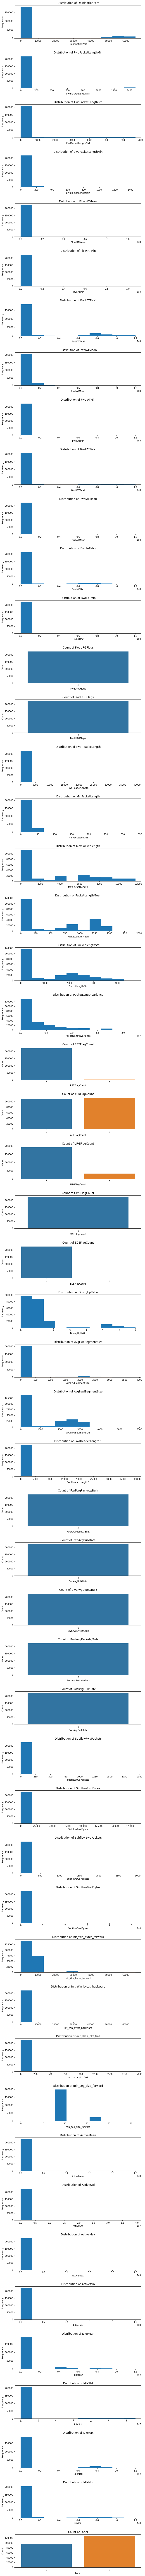

In [146]:
explore_features(df)

### Modeling

In [147]:
n_samples, n_features = df.shape

n_features = n_features-1

X = df.drop(columns = ['Label'])
y = df['Label']

print(df.shape,X.shape,y.shape)

(223112, 52) (223112, 51) (223112,)


In [148]:
# create 10 folds for cross validation
folds = StratifiedKFold(n_splits = 10)
folds

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)

In [149]:
X_train, X_temp, y_train, y_temp = train_test_split(X,y,test_size =0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5)

Accuracy of LinearDiscriminantAnalysis(): 97.24803537813368%
F1 Score of LinearDiscriminantAnalysis(): 97.66947544219236%


(LinearDiscriminantAnalysis(), 97.24803537813368, 97.66947544219236)

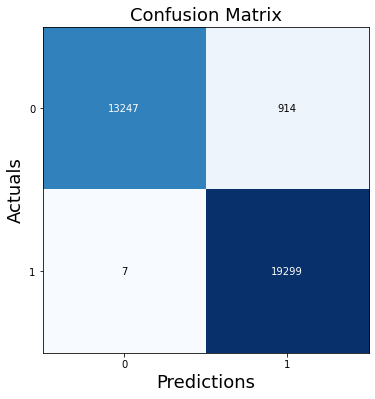

In [150]:
traditional_classification(LinearDiscriminantAnalysis(), X_train, X_test, y_train, y_test)

Accuracy_score: 97.42345272701661
precision_score: 95.75879483009501
recall_score: 99.93300580616346
f1_score: 97.80138123961886


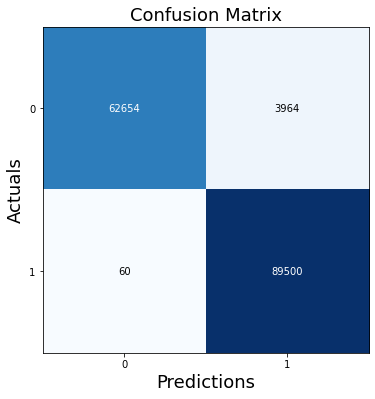

In [151]:
cross_validation_classification(LinearDiscriminantAnalysis(), X_train, X_test, y_train, y_test, folds)

Accuracy of RandomForestClassifier(n_estimators=15): 99.99402396390474%
F1 Score of RandomForestClassifier(n_estimators=15): 99.99482026313063%


(RandomForestClassifier(n_estimators=15), 99.99402396390474, 99.99482026313063)

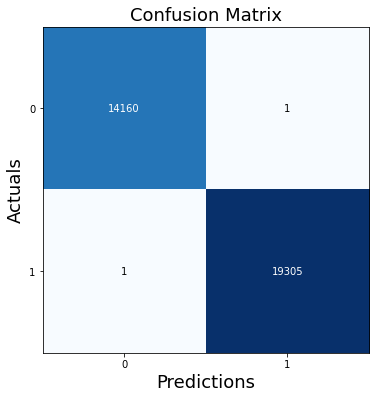

In [152]:
traditional_classification(RandomForestClassifier(n_estimators=15), X_train, X_test, y_train, y_test)

Accuracy_score: 99.99167616437654
precision_score: 99.9977666357718
recall_score: 99.98771773112996
f1_score: 99.99274193098134


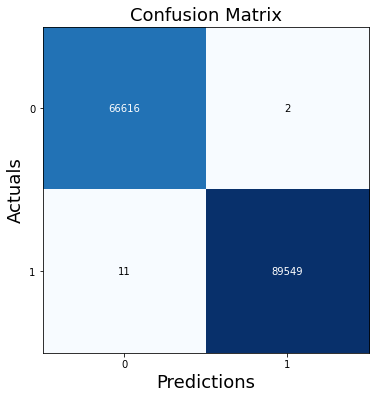

In [153]:
cross_validation_classification(RandomForestClassifier(n_estimators=15), X_train, X_test, y_train, y_test,folds)

In [154]:
# Enable categorical support for XGBoost in training set
for col in X_train.select_dtypes(include='category').columns:
    X_train[col] = X_train[col].cat.codes

# Enable categorical support for XGBoost in validation and test sets
for col in X_val.select_dtypes(include='category').columns:
    X_val[col] = X_val[col].cat.codes

for col in X_test.select_dtypes(include='category').columns:
    X_test[col] = X_test[col].cat.codes

# Create DMatrices for training, validation, and testing sets
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dval = xgb.DMatrix(X_val, label=y_val, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)


In [155]:
# XGBoost parameters
params = {
    'objective': 'binary:logistic',  # Adjust for your specific problem
    'eval_metric': 'logloss',  # Adjust as needed
    'seed': 42  # Set a seed for reproducibility
}

num_rounds = 1000  # Adjust the number of boosting rounds as needed
watchlist = [(dtrain, 'train'), (dval, 'validation')]  # Enable early stopping with a validation set

model = xgb.train(params, dtrain, num_rounds, evals=watchlist, early_stopping_rounds = 300)

# Make predictions on the test set
predictions = model.predict(dtest)

# Convert probabilities to binary predictions using a threshold
threshold = 0.5
binary_predictions = [1 if pred > threshold else 0 for pred in predictions]

# Evaluate the model on the test set
accuracy = accuracy_score(y_test, binary_predictions)
conf_matrix = confusion_matrix(y_test, binary_predictions)
class_report = classification_report(y_test, binary_predictions)

# Print the evaluation metrics
print(f"Accuracy: {accuracy:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)



[0]	train-logloss:0.43804	validation-logloss:0.43795
[1]	train-logloss:0.29715	validation-logloss:0.29708
[2]	train-logloss:0.20841	validation-logloss:0.20832
[3]	train-logloss:0.14905	validation-logloss:0.14896
[4]	train-logloss:0.10795	validation-logloss:0.10781
[5]	train-logloss:0.07883	validation-logloss:0.07870
[6]	train-logloss:0.05789	validation-logloss:0.05785
[7]	train-logloss:0.04274	validation-logloss:0.04269
[8]	train-logloss:0.03165	validation-logloss:0.03158
[9]	train-logloss:0.02359	validation-logloss:0.02351
[10]	train-logloss:0.01761	validation-logloss:0.01759
[11]	train-logloss:0.01321	validation-logloss:0.01317
[12]	train-logloss:0.00988	validation-logloss:0.00984
[13]	train-logloss:0.00746	validation-logloss:0.00745
[14]	train-logloss:0.00563	validation-logloss:0.00561
[15]	train-logloss:0.00432	validation-logloss:0.00428
[16]	train-logloss:0.00330	validation-logloss:0.00327
[17]	train-logloss:0.00252	validation-logloss:0.00252
[18]	train-logloss:0.00197	validation-